In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd 
import cv2

from matplotlib.colors import hsv_to_rgb , rgb_to_hsv
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import axes3d, Axes3D
import gc 
import time

from sklearn import linear_model

In [2]:
def read_im(fn) :
    return plt.imread(fn)/255
img4 = read_im("1.jpg")


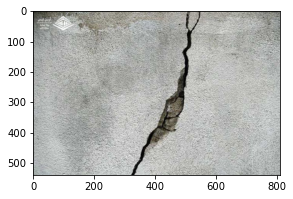

In [3]:
#Data visualization
plt.figure(figsize= (15, 80))

plt.subplot(131)
plt.imshow(img4)
plt.show()

In [4]:
def show_im(arr):
    arr3 = arr.copy()
    arr3[arr3 == -100] = 0
    plt.grid(False)
    plt.imshow(arr3)

def show_imgs_results ( img1 , img2 , img3 ): 

    plt.figure(figsize= (15, 80))

    plt.subplot(131)
    show_im(img1)
    plt.title('Original image')

    plt.subplot(132)
    show_im(img2)
    plt.title('Damaged image')

    plt.subplot(133)
    show_im(img3)
    plt.title('Restored image')

    plt.show()
def del_patch(img_arr, x_c, y_c, h):
    hole_arr = img_arr.copy()
    for i in range(int(x_c-h//2),int(x_c+h//2)):
        for j in range(int(y_c-h/2),int(y_c+h/2)):
            hole_arr[i,j] = np.array([-100,-100,-100])
    return hole_arr

def get_patch(img_arr, x_c, y_c, h):
    start_x, start_y = int(x_c - h//2), int(y_c - h//2)
    end_x, end_y = int(x_c + h//2), int(y_c + h//2)
    return img_arr[start_x:end_x, start_y:end_y, :].copy()

def fill_patch(img_arr, x_c, y_c, h, values):
    start_x, start_y = int(x_c - h//2), int(y_c - h//2)
    end_x, end_y = int(x_c + h//2), int(y_c + h//2)
    img_arr[start_x:end_x, start_y:end_y, :] = values.reshape(h,h,3)
    
def naive_high_priority_pixel (img_arr, h, boundary_pixels):
    priority = -1 
    prior_pixel = (-1,-1)
    prior_patch = None
    for pixel in boundary_pixels :
        p = get_patch ( img_arr , pixel[0] , pixel[1] , h ).ravel()
        count_px_complete = np.argwhere(p != -100).shape[0]
        if ( count_px_complete > priority ):
            priority = count_px_complete
            prior_pixel = pixel
            prior_patch = p
            
    return prior_pixel , prior_patch

def get_boundary_pixels(img_arr):
    channel1 = img_arr[:,:,0].reshape(img_arr.shape[0], img_arr.shape[1])
    w, h = channel1.shape
    boundary = set()
    for i in range(w):
        for j in range(h):
            pixel_val = channel1[i,j]
            if (pixel_val == -100):
                if(channel1[i,j-1]!=-100 or channel1[i,j+1]!=-100 or channel1[i-1,j]!=-100 or channel1[i-1,j]!=-100):
                    boundary.add((i,j))
    return boundary

def get_dictionary(img_arr, h, stride):
    dic = []
    X, Y, _ = img_arr.shape
    for i in range(0, X - h, stride):
        for j in range(0, Y - h, stride):
            elem_to_find = -100
            patch = get_patch(img_arr, i+h//2, j+h//2, h).ravel()
            found = elem_to_find in patch
            if not found:
                dic.append(patch)
    return np.array(dic).T



In [5]:
def Inpainting (img_path , h , stride , i , j , height , alpha, max_iter = 60000, verbose=True):
    t_init = time.time()
    array_img =  read_im(img_path)
    print("image shape : " , array_img.shape )

  #rgb TO hsv
    imgNormalized_hsv = rgb_to_hsv(array_img)

    img_hole = del_patch(imgNormalized_hsv, i, j, height)
    img_hole_rgb = del_patch(array_img, i, j, height)
    
    b_pixels = get_boundary_pixels(img_hole)
    
    D = get_dictionary(img_hole, h, stride)
    print("dictionary shape : " , D.shape )
    
    model = linear_model.Lasso(alpha=alpha, max_iter=max_iter)
    # ALGORITHM 
    i  = 0

    while (len(b_pixels) > 0):
        gc.collect()
        
        centre_pixel, Y = naive_high_priority_pixel(img_hole, h, b_pixels)
        Y = Y.ravel()
        train_iter = []
        test_iter = []
        for k in range(len(Y)):
            if(Y[k]==-100):
                test_iter.append(k)
            else:
                train_iter.append(k)
        model.fit(D[train_iter], Y[train_iter])
        if ( verbose ) :
            print("iteration ",i," len b_pixel : ",len(b_pixels))
            print("selected pixel : ",centre_pixel)
            print("selected patch shape : ",Y.shape )
            print("number of none zero components: {0:.2f}  %".format(100*np.where ( model.coef_ != 0 )[0].shape[0]/D.shape[1]))
        Y_pred = model.predict(D[test_iter])
        Y[test_iter] = Y_pred
        fill_patch(img_hole, centre_pixel[0], centre_pixel[1], h, Y)
        b_pixels = get_boundary_pixels(img_hole)
        i += 1
        
    result_rgb = hsv_to_rgb(img_hole)

    print("elapsed time: {0:.2f} seconds".format(time.time() - t_init))
    # Plotting résults  
    show_imgs_results ( array_img , img_hole_rgb , result_rgb )
  

In [ ]:
Inpainting ( "1.jpg" , h=40 , stride=7 , alpha=1e-4 , i=124 , j=229 , height=81, max_iter = 7000, verbose = True)

image shape :  (539, 810, 3)
dictionary shape :  (2700, 4895)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12564347910134477, tolerance: 0.017189466028396442
  model = cd_fast.enet_coordinate_descent(


iteration  0  len b_pixel :  124
selected pixel :  (119, 69)
selected patch shape :  (2700,)
number of none zero components: 6.76  %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13535851471846772, tolerance: 0.01872496923522977
  model = cd_fast.enet_coordinate_descent(


iteration  1  len b_pixel :  123
selected pixel :  (134, 69)
selected patch shape :  (2700,)
number of none zero components: 6.93  %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08654572406743122, tolerance: 0.01816796319250969
  model = cd_fast.enet_coordinate_descent(


iteration  2  len b_pixel :  123
selected pixel :  (156, 69)
selected patch shape :  (2700,)
number of none zero components: 6.39  %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05252479092604512, tolerance: 0.018433023928595478
  model = cd_fast.enet_coordinate_descent(


iteration  3  len b_pixel :  109
selected pixel :  (119, 84)
selected patch shape :  (2700,)
number of none zero components: 6.19  %
iteration  4  len b_pixel :  108
selected pixel :  (119, 105)
selected patch shape :  (2700,)
number of none zero components: 6.52  %
iteration  5  len b_pixel :  79
selected pixel :  (134, 84)
selected patch shape :  (2700,)
number of none zero components: 5.64  %
iteration  6  len b_pixel :  78
selected pixel :  (150, 84)
selected patch shape :  (2700,)
number of none zero components: 5.97  %
iteration  7  len b_pixel :  64
selected pixel :  (134, 103)
selected patch shape :  (2700,)
number of none zero components: 6.15  %
iteration  8  len b_pixel :  34
selected pixel :  (149, 104)
selected patch shape :  (2700,)
number of none zero components: 5.43  %
elapsed time: 5950.98 seconds


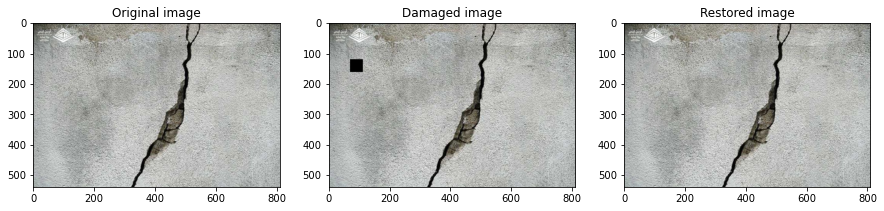

In [6]:
Inpainting ( "1.jpg" , h=30 , stride=9 , alpha=1e-4 , i=140 , j=90 , height=42)